In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import matplotlib.image as img
from PIL import Image
import cv2
from pathlib import Path
from typing import Dict, List, Tuple
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
data = np.load("./Wafer_Map_Datasets.npz")
print(data.files)

/Users/yuan/miniconda3/envs/shap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['arr_0', 'arr_1']


In [2]:
arrays = data['arr_0']
label = data['arr_1']
# print(arrays.shape)
arrays = np.reshape(arrays,(38015,52*52))
combine_array = np.concatenate([label,arrays],axis=1)
# print(combine_array.shape)

np.random.shuffle(combine_array)

# 設定每個集合的大小
total_rows = combine_array.shape[0]  # 總行數
train_size = int(total_rows * 0.7)  # 訓練集大小 (70%)
val_size = int(total_rows * 0.15)   # 驗證集大小 (15%)
test_size = total_rows - train_size - val_size  # 測試集大小 (剩下的行數)

# 分割數據集
train_set = combine_array[:train_size]  # 前 70% 為訓練集
val_set = combine_array[train_size:train_size + val_size]  # 接下來的 15% 為驗證集
test_set = combine_array[train_size + val_size:]  # 剩下的 15% 為測試集

print("訓練集筆數:", train_set.shape[0])
print("驗證集筆數:", val_set.shape[0])
print("測試集筆數:", test_set.shape[0])

train_X = train_set[:,8: ]
train_Y = train_set[:, :8]
val_X = val_set[:,8: ]
val_Y = val_set[:, :8]
test_X = test_set[:,8: ]
test_Y = test_set[:, :8]

train_X = np.reshape(train_X,(-1,52,52))
val_X = np.reshape(val_X,(-1,52,52))
test_X = np.reshape(test_X,(-1,52,52))

print(train_X.shape)

訓練集筆數: 26610
驗證集筆數: 5702
測試集筆數: 5703
(26610, 52, 52)


In [3]:
# 看各 label 個數
print(pd.DataFrame(train_Y).value_counts())

def decode_to_38bit(input_ndarray):
    mapping = {
        "00000000": 0,
        "10000000": 1,
        "01000000": 2,
        "00100000": 3,
        "00010000": 4,
        "00001000": 5,
        "00000100": 6,
        "00000010": 7,
        "00000001": 8,
        "10100000": 9,
        "10010000": 10,
        "10001000": 11,
        "10000010": 12,
        "01100000": 13,
        "01010000": 14,
        "01001000": 15,
        "01000010": 16,
        "00101000": 17,
        "00100010": 18,
        "00011000": 19,
        "00010010": 20,
        "00001010": 21,
        "10101000": 22,
        "10100010": 23,
        "10011000": 24,
        "10010010": 25,
        "10001010": 26,
        "01101000": 27,
        "01100010": 28,
        "01011000": 29,
        "01010010": 30,
        "01001010": 31,
        "00101010": 32,
        "00011010": 33,
        "10101010": 34,
        "10011010": 35,
        "01101010": 36,
        "01011010": 37
    }

    n = input_ndarray.shape[0]  # 行數
    decoded_ndarray = np.zeros(n, dtype=int)

    # 逐行解碼
    for i, row in enumerate(input_ndarray):
        # 將每一行轉換為字典的鍵，並獲得對應的索引
        input_8bit = ''.join(row.astype(str))  # 把整數轉為字串並拼接

        number = mapping[input_8bit]  # 獲取對應的數字索引
        decoded_ndarray[i] = number

    return decoded_ndarray

# label 轉成 one hot encoding
train_Y = decode_to_38bit(train_Y)
val_Y = decode_to_38bit(val_Y)
test_Y = decode_to_38bit(test_Y)

0  1  2  3  4  5  6  7
1  0  1  0  0  0  1  0    1371
            1  0  0  0     726
0  1  1  0  0  0  0  0     725
   0  0  0  1  0  1  0     719
      1  0  0  0  1  0     719
1  0  0  1  1  0  0  0     717
                  1  0     715
         0  0  0  0  0     714
0  1  1  0  1  0  0  0     714
   0  0  0  1  0  0  0     712
   1  0  0  0  0  0  0     711
            1  0  0  0     710
   0  0  1  0  0  0  0     710
                  1  0     710
            1  0  0  0     710
   1  0  1  0  0  0  0     707
                  1  0     707
   0  0  0  0  0  1  0     707
1  0  0  1  0  0  1  0     705
0  1  0  0  1  0  1  0     701
         1  1  0  1  0     699
   0  1  0  1  0  1  0     698
1  0  1  0  0  0  0  0     697
      0  0  1  0  1  0     695
                  0  0     694
0  0  1  0  1  0  0  0     692
            0  0  0  0     690
      0  1  1  0  1  0     688
1  0  0  0  0  0  1  0     687
0  0  0  0  0  0  0  0     686
1  0  1  0  1  0  1  0     681
      0  1  0  0

(52, 52)
3


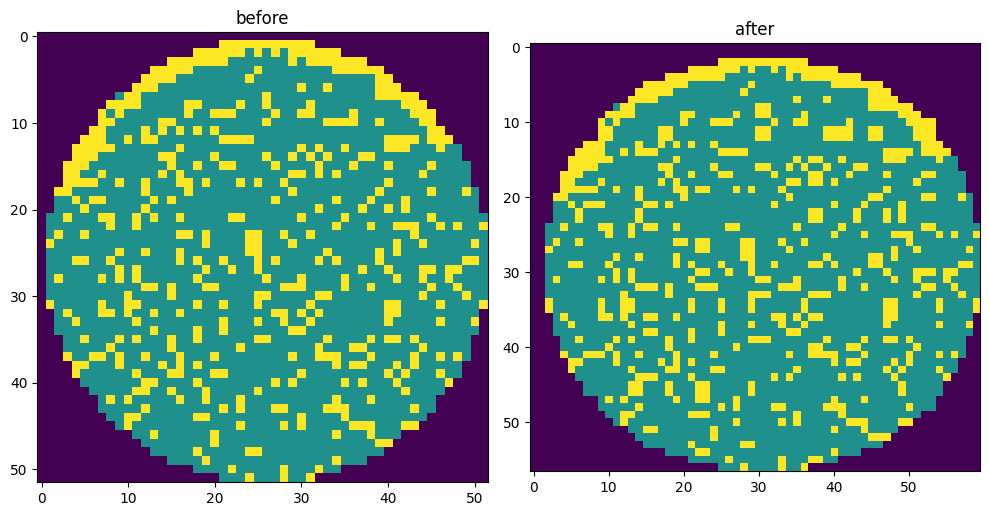

In [4]:
# 用來測試縮放
test_image = np.reshape(test_X[7],(52,52))
print(test_image.shape)
print(test_Y[7])

def resize_ndarray(input_array, target_height, target_width):
    # 使用 OpenCV 的 resize 函數進行調整
    resized_array = cv2.resize(input_array, (target_width, target_height), interpolation=cv2.INTER_NEAREST)
    return resized_array

resize_image = resize_ndarray(test_image, 57,60)

# 創建畫布，並劃分為 1 行 2 列
plt.figure(figsize=(10, 5))

# 第一張圖片
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("before")

# 第二張圖片
plt.subplot(1, 2, 2)
plt.imshow(resize_image)
plt.title("after")

# 顯示圖片
plt.tight_layout()
plt.show()

In [5]:
# 自定義一個簡單的 Dataset 類
class MyDataset(Dataset):
    def __init__(self,mydata,mylabel):
        # 定義數據
        self.data = mydata
        self.labels = mylabel

    def __len__(self):
        # 返回數據集的大小
        return len(self.data)

    def __getitem__(self, index):
        # 返回指定 index 的數據和標籤
        return self.data[index], self.labels[index]

# --- 使用本地 EfficientNet 模型的 CategoricalCNN ---
from transformers import EfficientNetForImageClassification, EfficientNetConfig

class CategoricalCNN(nn.Module):
    """
    專為二維類別資料（如晶圓圖）設計的 CNN。
    使用本地的 EfficientNet 模型。
    """
    def __init__(self, num_classes, num_categories=4, embedding_dim=16, model_path='./efficientnet_b0'):
        super().__init__()
        self.num_classes = num_classes
        self.num_categories = num_categories
        self.embedding_dim = embedding_dim

        # 1. 嵌入層，用於學習晶圓圖中各個類別的向量表示
        self.embedding = nn.Embedding(
            num_embeddings=num_categories, 
            embedding_dim=embedding_dim
        )

        # 2. 載入本地 EfficientNet 模型
        try:
            # 載入配置
            config = EfficientNetConfig.from_pretrained(model_path)
            
            # 修改配置以適應我們的需求
            config.num_channels = embedding_dim  # 修改輸入通道數
            config.num_labels = num_classes      # 修改輸出類別數
            
            # 載入模型
            self.backbone = EfficientNetForImageClassification.from_pretrained(
                model_path, 
                config=config,
                ignore_mismatched_sizes=True  # 忽略尺寸不匹配的層
            )
            
        except Exception as e:
            print(f"載入本地模型失敗: {e}")
            print("回退到 timm 模型...")
            # 回退方案：使用 timm
            import timm
            self.backbone = timm.create_model(
                'efficientnet_b0',
                pretrained=False,
                features_only=True,
                in_chans=embedding_dim
            )
            # 添加分類頭
            num_features = self.backbone.feature_info.channels(-1)
            self.global_pool = nn.AdaptiveAvgPool2d(1)
            self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        # x 的輸入形狀: (batch_size, height, width)，其值為整數類別
        x = x.long()

        # 通過嵌入層處理
        # 輸出形狀: (batch_size, height, width, embedding_dim)
        embedded_x = self.embedding(x)

        # 調整維度以匹配 CNN 的輸入格式 (N, C, H, W)
        # 輸出形狀: (batch_size, embedding_dim, height, width)
        embedded_x = embedded_x.permute(0, 3, 1, 2)

        # 通過 EfficientNet
        if hasattr(self, 'classifier'):  # timm 回退方案
            features = self.backbone(embedded_x)
            last_feature_map = features[-1]
            pooled_features = self.global_pool(last_feature_map).flatten(1)
            output = self.classifier(pooled_features)
        else:  # Hugging Face 模型
            outputs = self.backbone(embedded_x)
            output = outputs.logits

        return output

In [6]:
# 將原始的 one-hot 編碼資料賦予新的變數名稱，以符合後續程式碼的命名
train_Y_onehot = train_Y
val_Y_onehot = val_Y
test_Y_onehot = test_Y

# 調整圖片大小以符合模型預期
IMG_SIZE = 52

def resize_ndarray(input_array, target_height, target_width):
    # 使用 OpenCV 的 resize 函數進行調整
    return cv2.resize(input_array, (target_width, target_height), interpolation=cv2.INTER_NEAREST)

print(f"正在將晶圓圖大小從 (52, 52) 調整為 ({IMG_SIZE}, {IMG_SIZE})...")
resized_train_X = np.array([resize_ndarray(img, IMG_SIZE, IMG_SIZE) for img in tqdm(train_X, desc="調整訓練集大小")])
resized_val_X = np.array([resize_ndarray(img, IMG_SIZE, IMG_SIZE) for img in tqdm(val_X, desc="調整驗證集大小")])
resized_test_X = np.array([resize_ndarray(img, IMG_SIZE, IMG_SIZE) for img in tqdm(test_X, desc="調整測試集大小")])
print("大小調整完成。")


# --- 步驟 3: 更新 Dataset, Config 和訓練函式 ---

# 更新後的 Dataset，確保返回正確的資料類型
class WaferMapDataset(Dataset):
    def __init__(self, mydata, mylabel):
        # 將資料轉換為 LongTensor 以便嵌入層使用
        self.data = torch.from_numpy(mydata).long()
        # 將標籤轉換為 LongTensor 以便損失函式使用
        self.labels = torch.from_numpy(mylabel).long()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # 返回指定 index 的數據和標籤
        return self.data[index], self.labels[index]

# 更新後的 Config
class Config:
    def __init__(self):
        self.seed = 42
        self.image_size = IMG_SIZE
        self.batch_size = 16  # 如果記憶體不足 (CUDA out of memory)，可以降低此值
        self.num_workers = 0
        self.num_epochs = 30
        self.learning_rate = 5e-5
        
        # 本地模型路徑
        self.model_path_local = './efficientnet_b0'

        if torch.cuda.is_available():
            device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            device = torch.device('mps')
        else:
            device = torch.device('cpu')
        self.device = device
        
        self.output_dir = Path("./output")
        self.model_path = self.output_dir / "Custom_EfficientNet_model.pth"

        # CategoricalCNN 所需的新參數
        # 修正：晶圓圖資料中的獨特值數量 (0,1,2,3)
        self.num_categories = 3
        # 學習到的類別向量維度
        self.embedding_dim = 16

        # 類別和標籤
        self.num_classes = 38
        self.categories = [str(i) for i in range(self.num_classes)] # 用於分類報告


# 您的 train_epoch 和 validate 函式無需修改，這裡為了完整性而包含進來
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    with tqdm(train_loader, desc=f'Epoch {epoch + 1} - 訓練中') as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    return total_loss / len(train_loader)

@torch.no_grad()
def validate(model, val_loader, criterion, device, desc='驗證中'):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with tqdm(val_loader, desc=desc) as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'accuracy': f'{accuracy:.2f}%'})
    return total_loss / len(val_loader), 100 * correct / total

# --- 步驟 4: 更新主函式以使用新模型和資料 ---
def main():
    config = Config()
    config.output_dir.mkdir(exist_ok=True)
    print(f"使用設備: {config.device}")
    print(f"模型將儲存至: {config.model_path}")
    print(f"使用本地 EfficientNet 模型: {config.model_path_local}")

    # 設定隨機種子以確保可重現性
    torch.manual_seed(config.seed)
    np.random.seed(config.seed)
    random.seed(config.seed)

    # 初始化 Dataset 和 DataLoader
    train_dataset = WaferMapDataset(resized_train_X, train_Y)
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)

    val_dataset = WaferMapDataset(resized_val_X, val_Y)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, num_workers=config.num_workers)

    test_dataset = WaferMapDataset(resized_test_X, test_Y)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, num_workers=config.num_workers)

    # --- 關鍵變更：實例化使用本地 EfficientNet 的 CategoricalCNN 模型 ---
    model = CategoricalCNN(
        num_classes=config.num_classes,
        num_categories=config.num_categories,
        embedding_dim=config.embedding_dim,
        model_path=config.model_path_local
    ).to(config.device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.num_epochs)

    best_val_acc = 0
    for epoch in range(config.num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, config.device, epoch)
        val_loss, val_acc = validate(model, val_loader, criterion, config.device, desc=f'Epoch {epoch + 1} - 驗證中')
        scheduler.step()

        print(f'\nEpoch {epoch + 1}:')
        print(f'訓練損失: {train_loss:.4f}')
        print(f'驗證損失: {val_loss:.4f}, 驗證準確率: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), config.model_path)
            print(f'儲存最佳模型，驗證準確率: {val_acc:.2f}%')

    print("\n在測試集上評估最佳模型...")
    model.load_state_dict(torch.load(config.model_path))
    test_loss, test_acc = validate(model, test_loader, criterion, config.device, desc='測試中')
    print(f'\n測試準確率: {test_acc:.2f}%')

    print("\n正在生成分類報告...")
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='預測中'):
            images = images.to(config.device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    report = classification_report(all_labels, all_preds, target_names=config.categories, digits=4)
    print('\n分類報告:')
    print(report)

    with open(config.output_dir / 'classification_report.txt', 'w') as f:
        f.write(report)

main()

正在將晶圓圖大小從 (52, 52) 調整為 (52, 52)...


調整測試集大小: 100%|██████████| 5703/5703 [00:00<00:00, 568524.88it/s]

大小調整完成。


使用設備: mps
模型將儲存至: output/Custom_EfficientNet_model.pth
使用本地 EfficientNet 模型: ./efficientnet_b0


Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at ./efficientnet_b0 and are newly initialized because the shapes did not match:
- efficientnet.embeddings.convolution.weight: found shape torch.Size([32, 3, 3, 3]) in the checkpoint and torch.Size([32, 16, 3, 3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([38, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([38]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - 訓練中:   2%|▏         | 26/1664 [00:15<16:34,  1.65it/s, loss=3.8703] 


KeyboardInterrupt: 

In [ ]:
# Check for shufflenet models
shufflenet_models = timm.list_models('*shufflenet*')
print(f"Available ShuffleNet models: {shufflenet_models}")

# Check for mobilenet models (good alternatives)
mobilenet_models = timm.list_models('*mobilenet*')
print(f"Available MobileNet models (first 5): {mobilenet_models[:5]}")

# Check for efficientnet models (also good alternatives)
efficientnet_models = timm.list_models('*efficientnet*')
print(f"Available EfficientNet models (first 5): {efficientnet_models[:5]}")